## Required Libraries

In [1]:
import numpy as np
import pandas as pd
from scipy import optimize
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [2]:
# To set the current working directory (Optional)
from os import chdir
chdir("Path_To_Directory_Containing_Data_File")

## Helper Functions

In [3]:
def normalizeRatings(Y, R):
    """
    Preprocess data by subtracting mean rating for every movie (every row).
    Parameters
    ----------
    Y : array_like
        The user ratings for all movies. A matrix of shape
        (num_movies x num_users).

    R : array_like
        Indicator matrix for movies rated by users. A matrix of shape
        (num_movies x num_users).
    Returns
    -------
    Ynorm : array_like
        A matrix of same shape as Y, after mean normalization.
    Ymean : array_like
        A vector of shape (num_movies, ) containing the mean rating
        for each movie.
    """

    m, n = Y.shape
    Ymean = np.zeros(m)
    Ynorm = np.zeros(Y.shape)

    for i in range(m):
        idx = R[i, :] == 1
        Ymean[i] = np.mean(Y[i, idx])
        Ynorm[i, idx] = Y[i, idx] - Ymean[i]

    return Ynorm, Ymean


def cofiCostFunc(params, Y, R, num_users, num_movies,
                 num_features, lambda_=0.0):
    """
    Collaborative filtering cost function.

    Parameters
    ----------
    params : array_like
        The parameters which will be optimized. This is a one
        dimensional vector of shape (num_movies x num_users, 1). It is the
        concatenation of the feature vectors X and parameters Theta.

    Y : array_like
        A matrix of shape (num_movies x num_users) of user ratings of movies.

    R : array_like
        A (num_movies x num_users) matrix, where R[i, j] = 1 if the
        i-th movie was rated by the j-th user.

    num_users : int
        Total number of users.

    num_movies : int
        Total number of movies.

    num_features : int
        Number of features to learn.

    lambda_ : float, optional
        The regularization coefficient.

    Returns
    -------
    J : float
        The value of the cost function at the given params.

    grad : array_like
        The gradient vector of the cost function at the given params.
        grad has a shape (num_movies x num_users, 1)
    """

    # Unfold the U and W matrices from params
    X = params[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features)

    # You need to return the following values correctly
    J = 0
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)

    J = (1 / 2) * np.sum(
        np.square((X.dot(Theta.T) - Y) * R)) + \
        (lambda_ / 2) * np.sum(np.square(X)) + \
        (lambda_ / 2) * np.sum(np.square(Theta))

    for i in range(R.shape[0]):

        idx = np.where(R[i, :] == 1)[0]
        Theta_temp = Theta[idx, :]
        Y_temp = Y[i, idx]
        X_grad[i, :] = np.dot(
            np.dot(X[i, :], Theta_temp.T) - Y_temp, Theta_temp
            ) + lambda_ * X[i, :]

    for j in range(R.shape[1]):

        idx = np.where(R[:, j] == 1)[0]
        X_temp = X[idx, :]
        Y_temp = Y[idx, j]
        Theta_grad[j, :] = np.dot(
            np.dot(X_temp, Theta[j, :]) - Y_temp, X_temp
            ) + lambda_ * Theta[j, :]

    grad = np.concatenate([X_grad.ravel(), Theta_grad.ravel()])
    return J, grad

## Importing Data

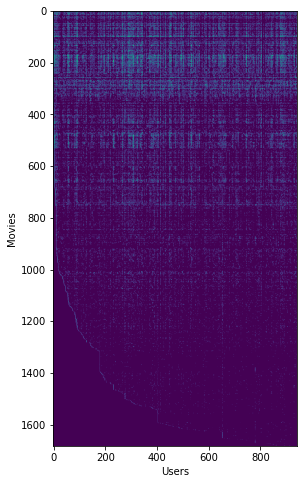

In [4]:
# Load data
data = loadmat("ex8_movies.mat")
Y, R = data['Y'], data['R']

# Y is a 1682x943 matrix, containing ratings (1-5) of
# 1682 movies on 943 users

# R is a 1682x943 matrix, where R(i,j) = 1
# if and only if user j gave a rating to movie i

# We can "visualize" the ratings matrix by plotting it with imshow
plt.figure(figsize=(8, 8))
plt.imshow(Y)
plt.ylabel('Movies')
plt.xlabel('Users')
plt.grid(False)

## Data Preprocessing

In [5]:
movieList = pd.Series(index=range(1682), dtype="object")
with open("movie_ids.txt") as m:
    for i in range(1682):
        words = m.readline().split()
        now = " ".join(words[1:])
        movieList[int(words[0]) - 1] = now


n_m = len(movieList)

In [6]:
#  Initialize my ratings
my_ratings = np.zeros(n_m)

# Check the file movie_idx.txt for id of each movie in our dataset
# For example, Toy Story (1995) has ID 1, so to rate it "4", you can set
# Note that the index here is ID-1, since we start index from 0.
# my_ratings[0] = 4

# # Or suppose did not enjoy Silence of the Lambs (1991), you can set
# my_ratings[97] = 2

# # We have selected a few movies we liked / did not like and the ratings we
# # gave are as follows:
# my_ratings[6] = 1
# my_ratings[11] = 1
# my_ratings[53] = 1
# my_ratings[63] = 1
# my_ratings[65] = 1
# my_ratings[68] = 1
# my_ratings[182] = 1
# my_ratings[225] = 1
# my_ratings[354] = 1

my_ratings[200] = 5
my_ratings[440] = 5
my_ratings[183] = 5
my_ratings[184] = 5
my_ratings[441] = 5
my_ratings[447] = 5
my_ratings[551] = 5


#  Now, you will train the collaborative filtering model on a movie rating
#  dataset of 1682 movies and 943 users

#  Load data
data = loadmat("ex8_movies.mat")
Y, R = data['Y'], data['R']

#  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies by
#  943 users

#  R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a
#  rating to movie i

#  Add our own ratings to the data matrix
Y = np.hstack([my_ratings[:, None], Y])
R = np.hstack([(my_ratings > 0)[:, None], R])

#  Normalize Ratings
Ynorm, Ymean = normalizeRatings(Y, R)

#  Useful Values
num_movies, num_users = Y.shape
num_features = 10

## Training Our Model (Parameter Estimation)

In [7]:
# Set Initial Parameters (Theta, X)
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)

initial_parameters = np.concatenate([X.ravel(), Theta.ravel()])

# Set options for scipy.optimize.minimize
options = {'maxiter': 100}

# Set Regularization
lambda_ = 50
res = optimize.minimize(lambda x: cofiCostFunc(x, Ynorm, R, num_users,
                                               num_movies, num_features,
                                               lambda_),
                        initial_parameters,
                        method='TNC',
                        jac=True,
                        options=options)
theta = res.x

# Unfold the returned theta back into U and W
X = theta[:num_movies*num_features].reshape(num_movies, num_features)
Theta = theta[num_movies*num_features:].reshape(num_users, num_features)

print('Recommender system learning completed.')

Recommender system learning completed.


## Let's Find Our Top 10 Recommended Movies

In [8]:
p = np.dot(X, Theta.T)
my_predictions = p[:, 0] + Ymean

ix = np.argsort(my_predictions)[::-1]

print('Top recommendations for you:')
print('----------------------------')
for i in range(10):
    j = ix[i]
    print('Predicting rating %.1f for movie %s' % (
        my_predictions[j], movieList[j]))

print('\nOriginal ratings provided:')
print('--------------------------')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated %d for %s' % (my_ratings[i], movieList[i]))

Top recommendations for you:
----------------------------
Predicting rating 5.0 for movie Prefontaine (1997)
Predicting rating 5.0 for movie Marlene Dietrich: Shadow and Light (1996)
Predicting rating 5.0 for movie Entertaining Angels: The Dorothy Day Story (1996)
Predicting rating 5.0 for movie Someone Else's America (1995)
Predicting rating 5.0 for movie Great Day in Harlem, A (1994)
Predicting rating 5.0 for movie Santa with Muscles (1996)
Predicting rating 5.0 for movie Aiqing wansui (1994)
Predicting rating 5.0 for movie Star Kid (1997)
Predicting rating 5.0 for movie They Made Me a Criminal (1939)
Predicting rating 5.0 for movie Saint of Fort Washington, The (1993)

Original ratings provided:
--------------------------
Rated 5 for Army of Darkness (1993)
Rated 5 for Psycho (1960)
Rated 5 for Evil Dead II (1987)
Rated 5 for Amityville Horror, The (1979)
Rated 5 for Amityville Curse, The (1990)
Rated 5 for Omen, The (1976)
Rated 5 for Species (1995)


## Note:
1. num_features is a parameter related to the possible tastes of the user's population, not easy to estimate.
2. Selecting few features should produce high Bias, too many features high Variance.
3. The Best way to select this parameter would be plotting learning curve.